<center><img src='../../img/ai4eo_logos.jpg' alt='Logos AI4EO MOOC' width='80%'></img></center>

<hr>

<br>

<a href='https://www.futurelearn.com/courses/artificial-intelligence-for-earth-monitoring/1/steps/1280516' target='_blank'><< Back to FutureLearn</a><br>

# Supervised classification using Sentinel-2 data

<i>by [Artur Nowakowski](artur.nowakowski@wfp.org), Warsaw University of Technology, Poland </i>

<hr>

## Watch the video tutorial

In [1]:
from IPython.display import HTML
HTML('<div align="center"><iframe src="https://player.vimeo.com/video/631902342?h=05660ae838" width="640" height="360" frameborder="0" allow="autoplay; fullscreen; picture-in-picture" allowfullscreen align="middle"></iframe></div>')     

<hr>

## Introduction

This workflow introduces you to an example of a supervised land cover classification with Sentinel-2 data. The aim is to classify a Sentinel-2 image into four different land cover classes: `water surfaces`, `artificial surfaces`, `low vegetation` and `tree cover`. Supervised classification means that an algorithm is trained based on labelled training data and validated with labelled validation data. Both, training and validation data are prepared manually in most cases.
The workflow shows you an example of how to train, classify (predict) and evaluate three different supervised classifiers: `Decision Tree`, `Random Forest` and `Support Vector Machine (SVM)`.

See here an example of an [unsupervised classification of Sentinel-2 data](./3D2_unsupervised_classification_using_Sentinel-2.ipynb).

## Machine Learning model

This workflow introduces you to three popular algorithms used for supervised classifications:
* <a href='https://scikit-learn.org/stable/modules/tree.html' target='_blank'>Decision Tree</a>: a non-parametric supervised learning method
* <a href='https://scikit-learn.org/stable/modules/ensemble.html' target='_blank'>Random Forest</a>: an ensemble classification method, where several predictions of base estimators are combined
* <a href='https://scikit-learn.org/stable/modules/svm.html' target='_blank'>Support Vector Machine (SVM)</a>: a set of supervised learning methods used for classification, regression and outliers detection

The example makes use of the algorithms provided by the <a href='https://scikit-learn.org/stable/' target='_blank'>scikit-learn library</a>.

## Data

The workflow will guide you through the process to classify a pre-processed Sentinel-2 image subset. The following operations were conducted in before-hand on the original Sentinel-2 image file:
* `Subsetting` to a dimension of `(200, 600)` pixels
* `Resampling` of all 13 bands to a 10 m resolution, and
* `Saving` the 13 bands as individual `.tif` files

Additionally, a set of training and validation data points have been manually identified:
* `training data`: four .txt files containing 100 labelled training point locations (X and Y) for each of the land cover classes ([artifical surfaces](./training_data/artificial_surfaces.txt), [low vegetation](./training_data/low_vegetation.txt), [tree cover](./training_data/tree_cover.txt), [water](./training_data/water.txt))
* `validation data`: a [.txt file](./validation_data/validation_points.txt) containing 100 labelled training point locations together with the respective land cover class

## Further resources

* <a href='https://scikit-learn.org/stable/modules/tree.html' target='_blank'>Decision Trees - Scikit-learn documentation</a>
* <a href='https://scikit-learn.org/stable/modules/ensemble.html' target='_blank'>Ensemble methods - Scikit-learn documentation</a>
* <a href='https://scikit-learn.org/stable/modules/svm.html' target='_blank'>Support Vector Machines - Scikit-learn documentation</a>

<hr>

## Notebook outline

* [1 - Load and display a Sentinel-2 image](#load_s2_image_3d2)
* [2 - Load and display training point locations](#load_training_point_3d2)
* [3 - Data transformation for supervised classification](#data_transformation_3d2)
* [4 - Define and train three different supervised training classifiers](#training_classifiers_3d2)
* [5 - Classification of the Sentinel-2 image with the trained classifiers](#predict_3d2)
* [6 - Evaluate the classification performance](#evaluate_3d2)


<hr>

#### Import libraries

In [1]:
import numpy as np

from skimage import io
from skimage import exposure
from skimage.color import rgb2gray

import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

#### Helper function

In [2]:
def composition(band1,band2,band3):
    im_comp=np.dstack([band1/band1.max(), band2/band2.max(), band3/band3.max()])
    for i in range(3):
        v_min, v_max = np.percentile(im_comp[:,:,i],(1,98))
        im_comp[:,:,i] = exposure.rescale_intensity(im_comp[:,:,i],in_range=(v_min,v_max))
    return im_comp

<hr>

## <a id='load_s2_image_3d2'></a>1. Load and display a Sentinel-2 image

The first step is to inspect a Sentinel-2 image file, in order to better understand the file structure. Sentinel-2 carries a single `Multi-spectral Instrument (MSI)`, which provides 13 bands in the `visible`, `near-infrared` and `shortwave-infrared` spectrum with different ground resolutions:

|#|Name|Spatial Resolution|
|------------|----------------|-----------------|
|B1|Coastal aerosol|60|
|B2|Blue|10|
|B3|Green|10|
|B4|Red|10|
|B5|Red Edge 1|20|
|B6|Red Edge 2|20|
|B7|Red Edge 3|20|
|B8|Near-Infrared|10|
|B8a|Near-Infrared narrow|20|
|B9|Water vapor|60|
|B10|Shortwave-Infrared cirrus|60|
|B11|Shortwave Infrared 1|20|
|B12|Shortwave-Infrared 2|20|

A pre-processed Sentinel-2 image example is available in the folder `./S2_data/`. Originally, Sentinel-2 files are disseminated in the `SAFE` data format. For this example, the image has been preprocessed and each of the 13 band information saved as `.tif` file. Additionally, all bands were resampled to a resolution of 10m.

You can read multiple `tif` files with the function `ImageCollection` from the `io` module of the `skimage` library.

In [3]:
imFolder = './S2_data/'
coll = io.ImageCollection(imFolder + '*.tif')

# a list of loaded files
print(coll.files)

band_names=['B1','B2','B3','B4','B5','B6','B7','B8','B8A','B9','B10','B11','B12']

['./S2_data/B1.tif', './S2_data/B2.tif', './S2_data/B3.tif', './S2_data/B4.tif', './S2_data/B5.tif', './S2_data/B6.tif', './S2_data/B7.tif', './S2_data/B8.tif', './S2_data/B8a.tif', './S2_data/B9.tif', './S2_data/B10.tif', './S2_data/B11.tif', './S2_data/B12.tif']


<br>

In a next step, you can apply the helper function `composition()` in order to create a `True-Color-composite` of the bands in the visible spectrum: `B2`, `B3` and `B4`. The `composition()` function creates a numpy stack of the three bands and applies the function `rescale_intensity()` of the `exposure` module in order to adjust the composite's intensity levels to the images min and max reflectance values.

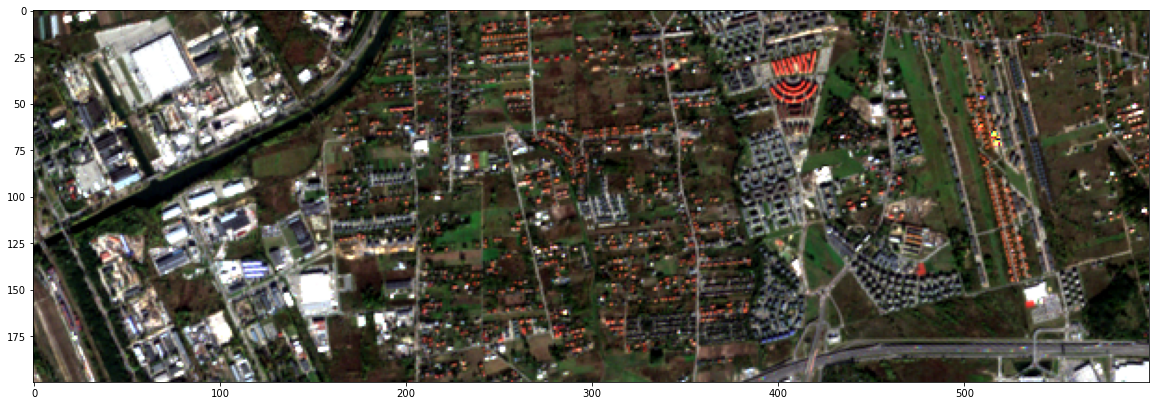

In [4]:
im_comp = composition(coll[3],coll[2],coll[1])
plt.figure(figsize=(20,10))
plt.imshow(im_comp)

<br>

## <a id='load_training_point_3d2'></a>2. Load and display training point locations

Supervised classfications require manually identified training points (labels) of example classes. We aim to classify each pixel of the Sentinel-2 image above into one of four land cover classes:
* `water`
* `artificial surfaces`
* `low vegetation`
* `tree cover`

In the folder `./training_data/`, you find four .txt files and each file contains the `Y` (horizontal pixel coordinate) and `X` (vertical pixel coordinate) of 100 manually identified training points (labels) for the respective land cover class. You can load .txt files with the function `loadtxt()` which is part of the numpy library.

In [6]:
p_water = np.loadtxt('./training_data/water.txt',dtype='int')
p_artificial = np.loadtxt('./training_data/artificial_surfaces.txt',dtype='int')
p_low_veg = np.loadtxt('./training_data/low_vegetation.txt',dtype='int')
p_trees = np.loadtxt('./training_data/tree_cover.txt',dtype='int')

LC_class_names = ['water', 'artificial', 'low vegetation', 'tree cover']

<br>

With the `X` and `Y` pixel coordinate information of the training point, you can go ahead and colorize the respective pixels that are used as training point. You can convert the underlying Sentinel-2 image into grayscale with the function `rgb2gray()`.

The following colors are applied to the training points of the four land cover classes:
* `Water - Blue`
* `Artificial surfaces - Red`
* `Low vegetation - Yellow`
* `Tree cover - Green`

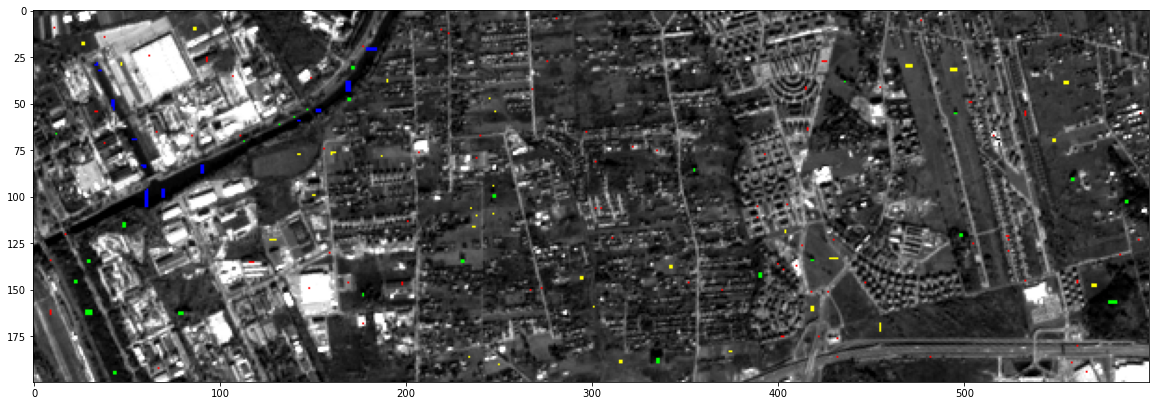

In [7]:
im_comp_p=np.zeros(im_comp.shape)
im_comp_p[:,:,0]=rgb2gray(im_comp)
im_comp_p[:,:,1]=rgb2gray(im_comp)
im_comp_p[:,:,2]=rgb2gray(im_comp)

# marking in blue the training points for 'water' class
im_comp_p[p_water[:,0],p_water[:,1],0] =0
im_comp_p[p_water[:,0],p_water[:,1],1] =0
im_comp_p[p_water[:,0],p_water[:,1],2] =1

# marking in red the training points for 'artificial surfaces' class
im_comp_p[p_artificial[:,0],p_artificial[:,1],0] =1
im_comp_p[p_artificial[:,0],p_artificial[:,1],1] =0
im_comp_p[p_artificial[:,0],p_artificial[:,1],2] =0

# marking in yellow the training points for 'low vegetation' class
im_comp_p[p_low_veg[:,0],p_low_veg[:,1],0] =1
im_comp_p[p_low_veg[:,0],p_low_veg[:,1],1] =1
im_comp_p[p_low_veg[:,0],p_low_veg[:,1],2] =0

# marking in green the training points for 'tree cover' class
im_comp_p[p_trees[:,0],p_trees[:,1],0] =0
im_comp_p[p_trees[:,0],p_trees[:,1],1] =1
im_comp_p[p_trees[:,0],p_trees[:,1],2] =0

plt.figure(figsize=(20,10))
plt.imshow(im_comp_p)

<br>

## <a id='data_transformation_3d2'></a>3. Data transformation for supervised classification

The next step is to transform the training labels into a format the Machine Learning algorithms for supervised classifications will understand. 

The algorithm requires an input (`X`) and output (`y`) variable. The output will be one of the four land cover classes (`1 - Water`, `2 - Artificial surface`, `3 - Low vegetation` and `4 - Tree cover`. 
For the input (`X`) variable, we take for each of the training  points the information of the 13 Sentinel-2 bands. The resulting array has a shape of `[400, 13]`, which contains for each of the training points the data information of the 13 Sentinel-2 image bands.

![fig1_supervised.png](./code/figures/fig1_supervised.png)

<br>

The first step is to retrieve the information of the 13 Sentinel-2 image bands for the 100 training points for the  land cover class `1 - water`. For each band, the information of the 100 pixels is retrieved and the information is appended to the final `bands` list.

In [8]:
bands=[]
for i in range(len(coll)):
    band = np.asarray(coll[i].data)[p_water[:,0],p_water[:,1]]
    bands.append(band)

<br>

As a next step, you want to convert the list `bands` into a `numpy.ndarray`. You can convert a list into a multidimensional array with the function `np.stack()`. The resulting array needs to be transposed in order to have the 100 training points as rows and the 13 bands information as columns.

In [9]:
X_water=np.stack(bands).T
X_water.shape

(100, 13)

<br>

The same steps as above need to be repeated for each of the land cover classes. Thus, the next step is to retrieve the band information for the training pixels of the land cover class `2 - artificial surface`.

In [10]:
bands=[]
for i in range(len(coll)):
    band = np.asarray(coll[i].data)[p_artificial[:,0],p_artificial[:,1]]
    bands.append(band)

X_artificial=np.stack(bands).T
X_artificial.shape

(100, 13)

<br>

The next step is to repeat the same steps as above also for the land cover class `3 - low vegetation`.

In [11]:
bands=[]
for i in range(len(coll)):
    band = np.asarray(coll[i].data)[p_low_veg[:,0],p_low_veg[:,1]]
    bands.append(band)
    
# step 2 - stacking band vectors into a table    
X_low_veg=np.stack(bands).T
X_low_veg.shape

(100, 13)

<br>

And, last but not least, we repeat the same steps as above as well for the land cover class `4 - tree cover`.

In [12]:
bands=[]
for i in range(len(coll)):
    band = np.asarray(coll[i].data)[p_trees[:,0],p_trees[:,1]]
    bands.append(band)
    
X_trees=np.stack(bands).T
X_trees.shape

(100, 13)

<br>


For the final input data array (`X`), we combine the four data arrays into one, by concatenating the arrays by rows. The dimension of the final data array has 400 rows, which reflects the 400 training pixels for each land cover class and 13 columns, reflecting the Sentinel-2 band information for each training point.

In [13]:
# stacking data for all classes in one table
X=np.vstack((X_water,X_artificial,X_low_veg,X_trees))

X.shape

(400, 13)

<br>

As output data (`y`), we create an array with the respective land cover class of each training point. The final dimension of the output array is `(400, 1)`.

In [14]:
y=np.vstack((np.ones((X_water.shape[0], 1)),
             2*np.ones((X_artificial.shape[0], 1)),
             3*np.ones((X_low_veg.shape[0], 1)),
             4*np.ones((X_trees.shape[0], 1))))

y.shape

(400, 1)

<br>

## <a id='training_classifiers_3d2'></a>4. Define and train three different supervised training classifiers

Subsequently, we will define and train the following three supervised training algorithms: `Decision Tree`, `Random Forest` and `Support Vector Machine (SVM)`.

### 4.1 Train a Decision Tree classifier

A `Decision Tree` is a `single classifier`, which determines the land cover classification based on a set of rules, which are established during the training process. You can use the <a href='https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html' target='_blank'>DecisionTreeClassifier</a> class from scikit-learn's `tree` module. We only specify the hyperparameter `max_depth`, which defines the maximum depth of the decision tree. See the documentation for additional hyperparameters with which you are able to finetune the classification.

Once you defined the `DecisionTreeClassifier`, you can train (fit) the classifier onto the input (`X`) and output (`y`) data.

In [15]:
dt_clf = DecisionTreeClassifier(max_depth = 10) 

dt_clf.fit(X, np.ravel(y))

DecisionTreeClassifier(max_depth=10)

<br>

You can use the function `plot_tree()` to visualize the trained decision tree. You can specify the following keyword arguments:
* `feature_names` - `band names` and 
* `class_names` - `land cover class names` 

**Note:** you can double-click on the resulting image in order to zoom in.

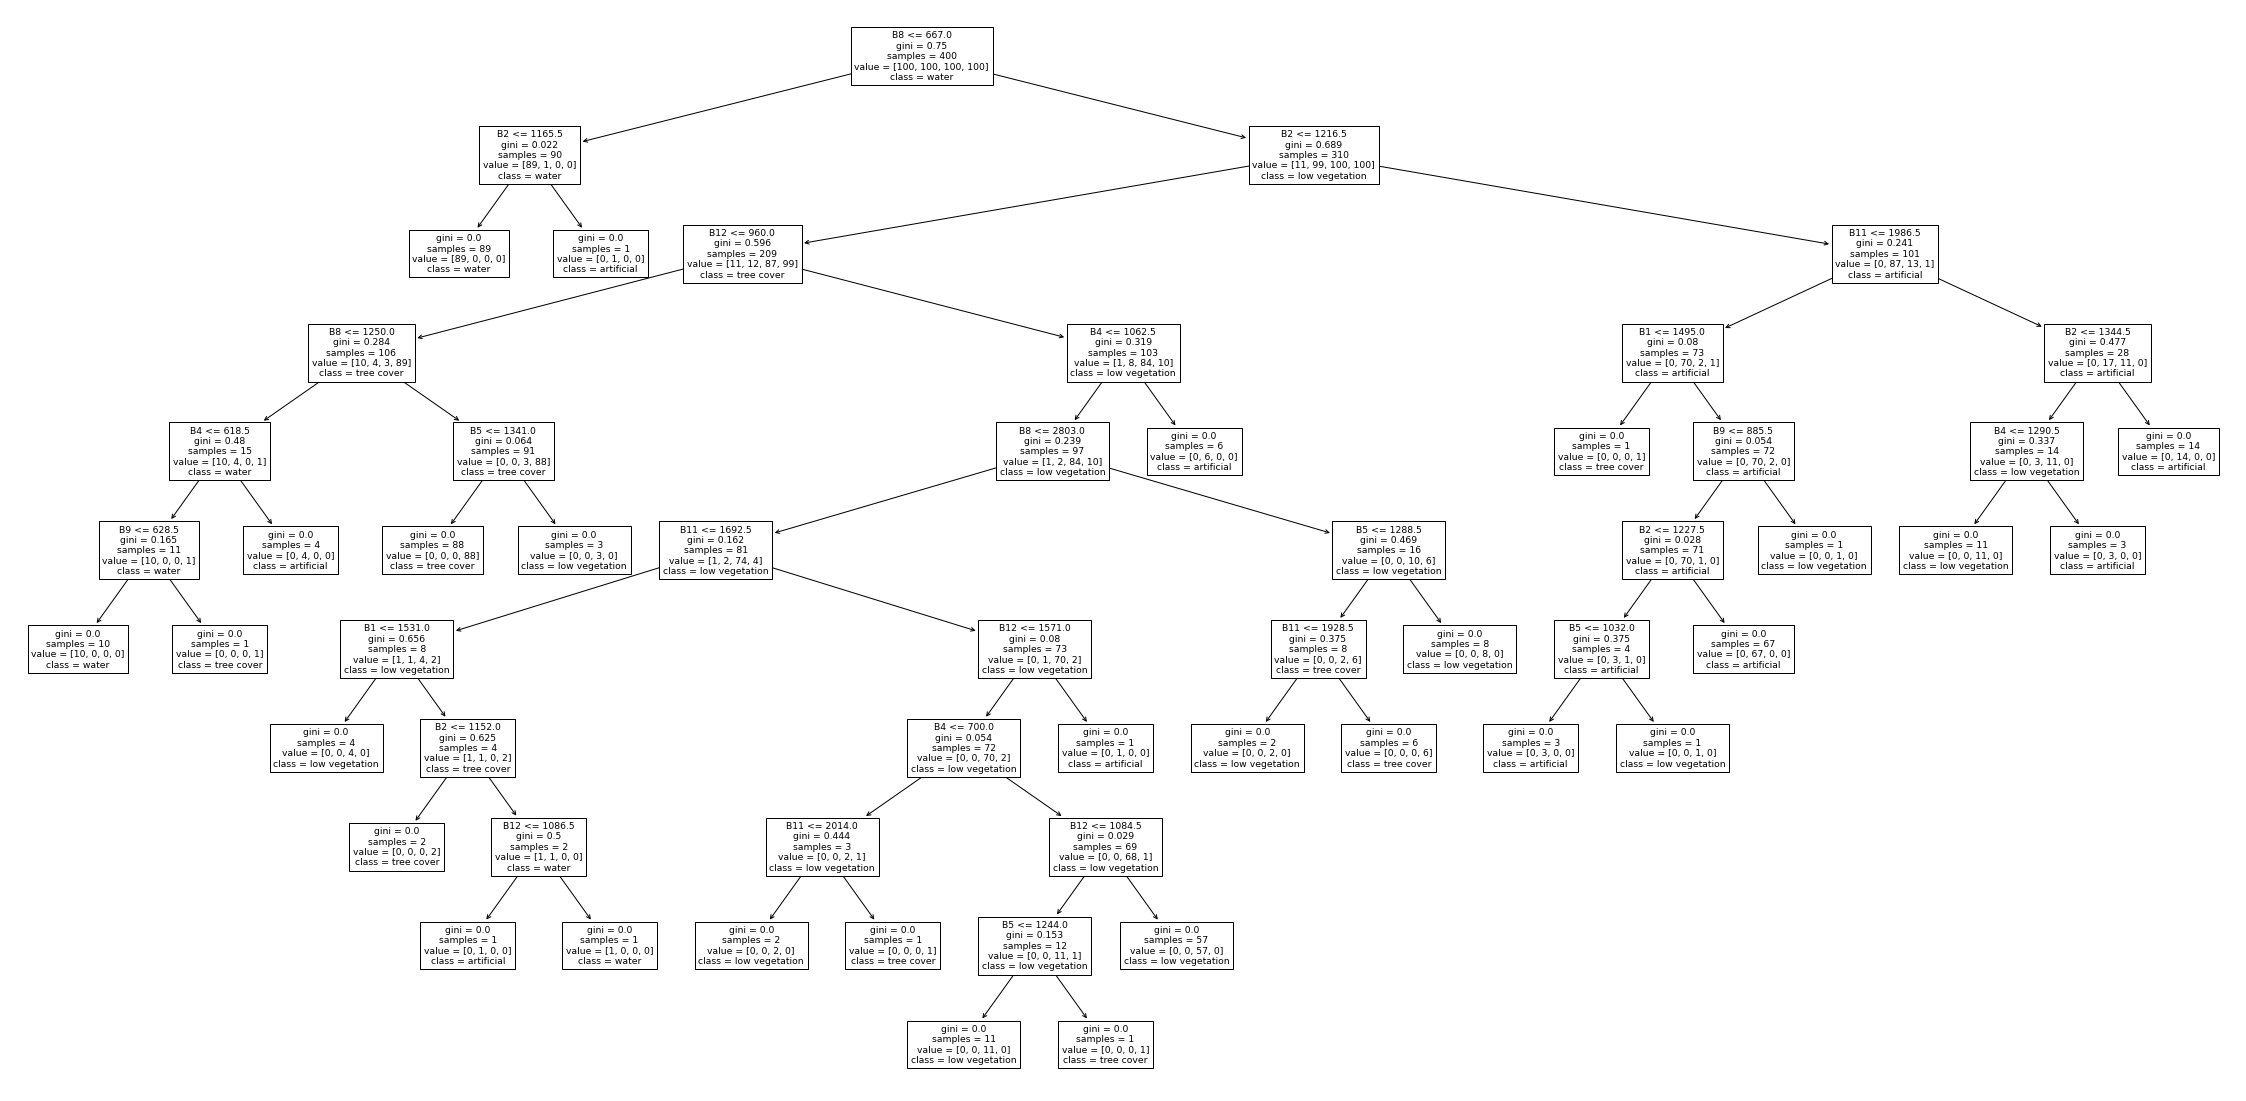

In [16]:
fig = plt.figure(figsize=(40,20))
plot_tree(dt_clf, 
          feature_names = band_names, 
          class_names = LC_class_names ) 
plt.show()

<br>

### 4.2 Train a Random Forest classifier

The next example defines and trains a `RandomForestClassifier`. Random Forest is a very common algorithm used for supervised classification. Instead of fitting only one decision tree, sub-samples of the dataset are fit to a number of decision tree classifiers.

You can use the <a href='https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html' target='_blank'>RandomForestClassifier</a> class from scikit-learn's `ensemble` module. The following hyperparameters are defined:
* `n_estimator`: number of trees per forecast
* `max_depth`: the maximum depth of the tree
* `random_state`: controls the randomness of the bootstrapping of the samples during the tree building process

See the algorithm documentation for a full list of possible hyperparameters.

Again, with the function `fit()`, you can train (fit) the defined model with the input (`X`) and output (`y`) variables.

In [17]:
rf_clf = RandomForestClassifier(n_estimators=10,
                             max_depth=5,
                             random_state=0)    

rf_clf.fit(X, np.ravel(y))

RandomForestClassifier(max_depth=5, n_estimators=10, random_state=0)

<br>

You can again apply the function `plot_tree()` to visualize the first N trees from the trained Random Forest.

**Note:** You can again double-click on the visualization in order to zoom into the tree.

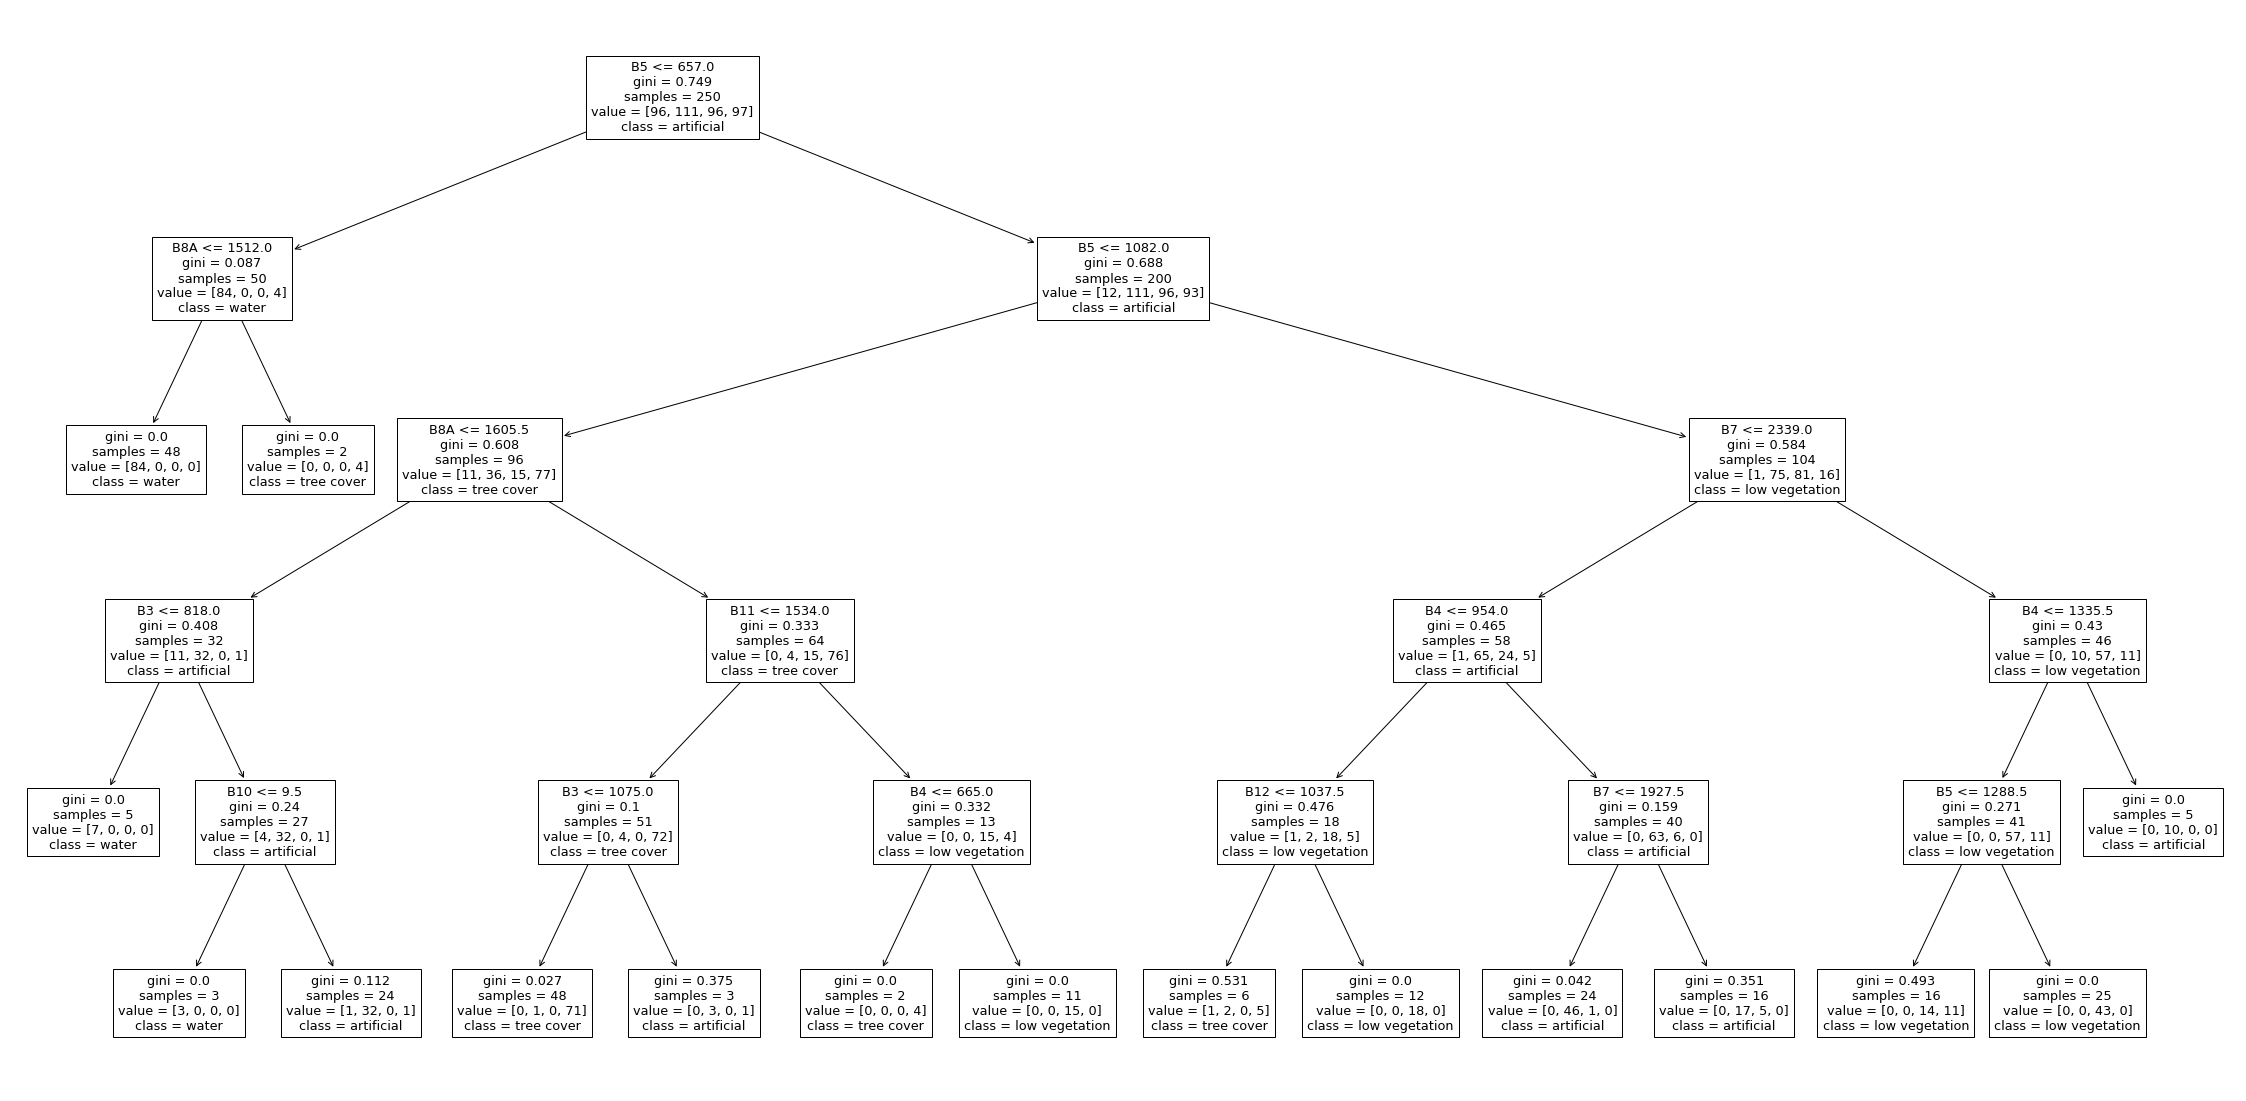

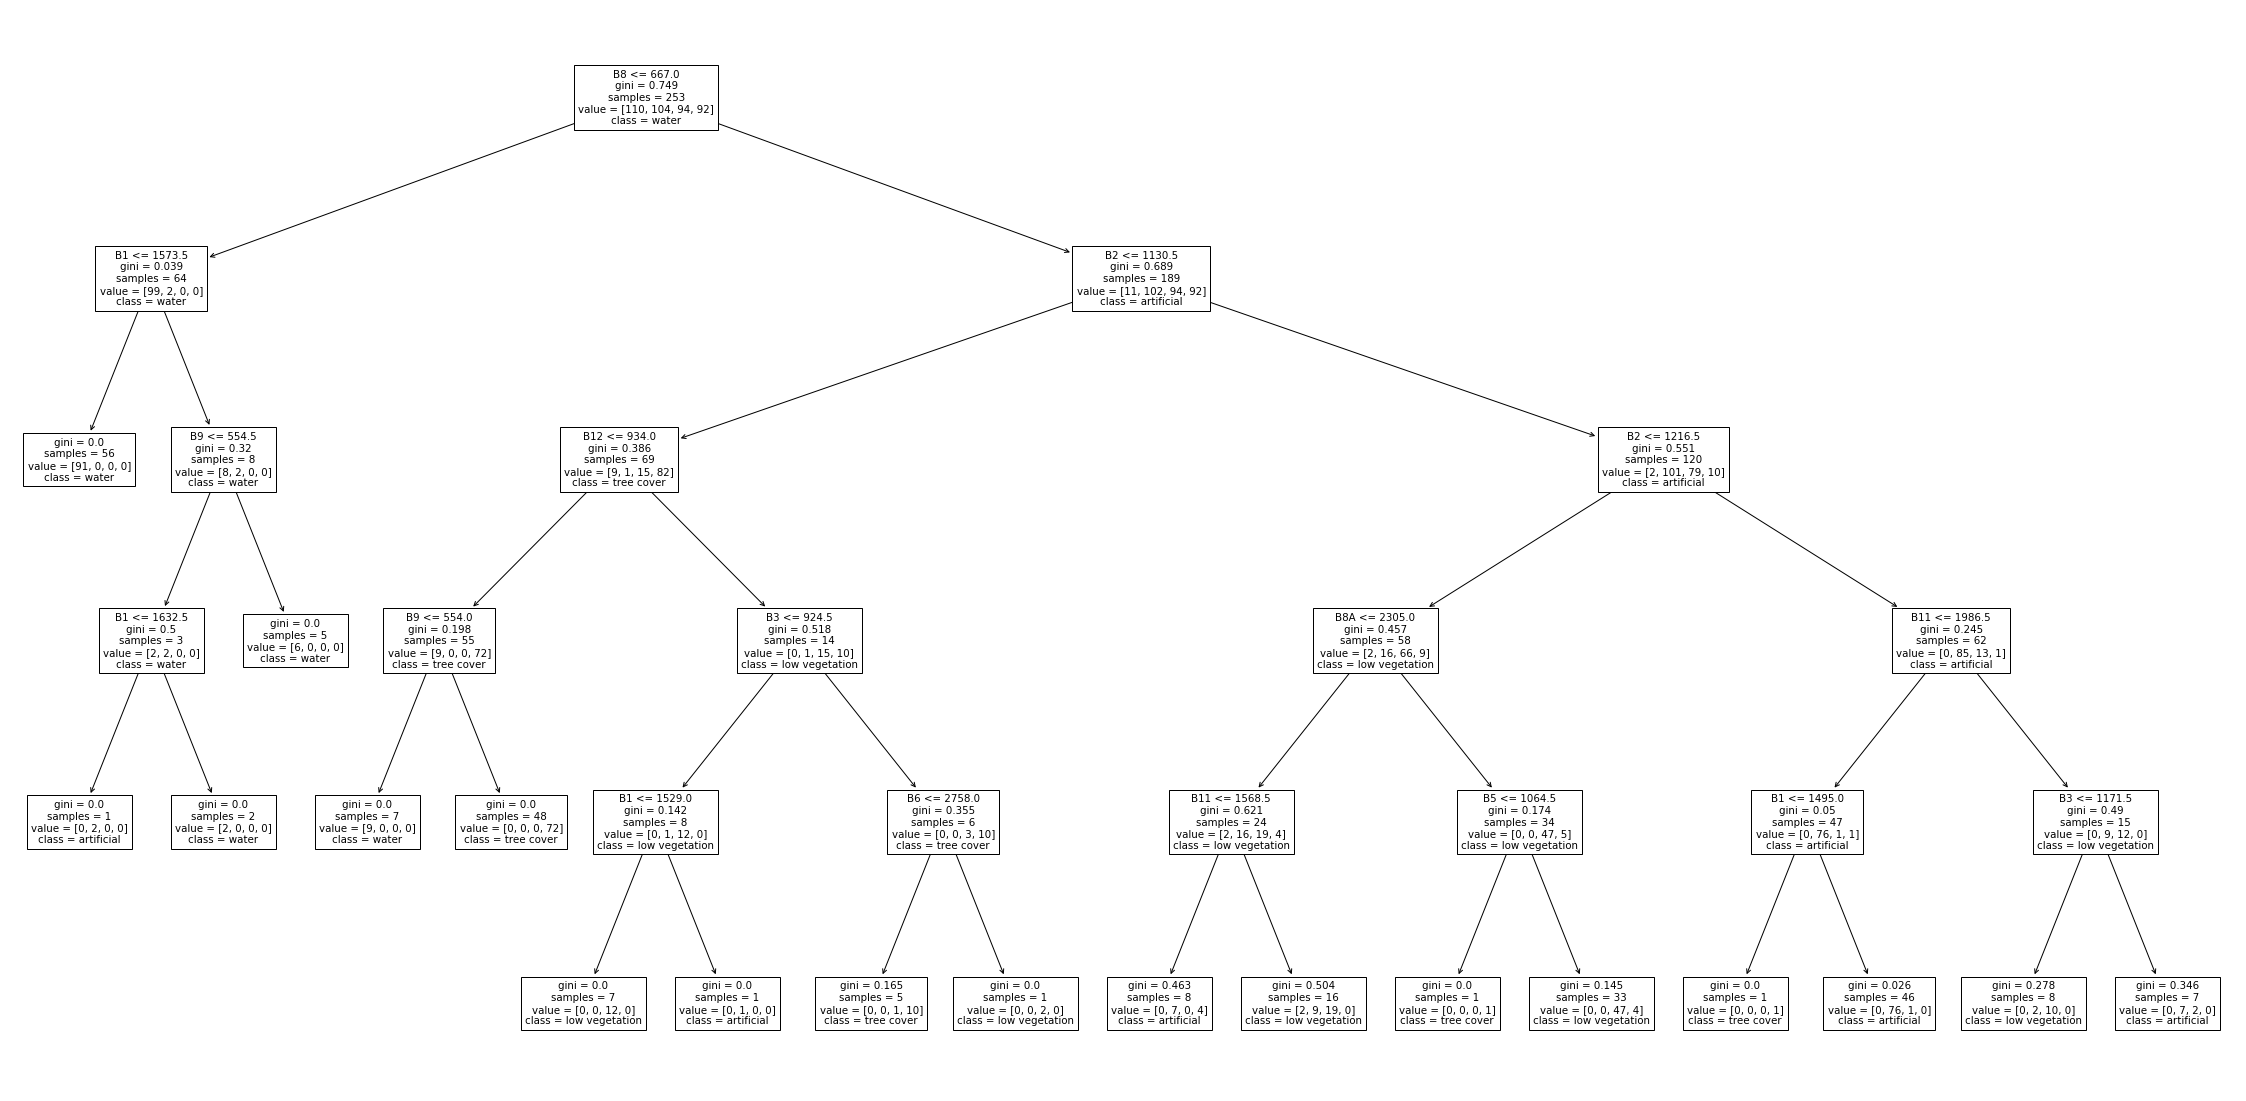

In [18]:
N=2

for i in range(N):
    fig = plt.figure(figsize=(40,20))
    plot_tree(rf_clf.estimators_[i],
              feature_names = band_names, 
              class_names = LC_class_names ) 
    plt.show()

<br>

### 4.3 Train a Support Vector Machine classifier

As a last classifier, we define and train a <a href='https://scikit-learn.org/stable/modules/svm.html' target='_blank'>Support Vector Machine (SVM)</a>. `SVM` is a classifier which builds a hyperplane feature space to separate classes. You can use the `SVC()` class from scikit-learn's `svm` module. The <a href='https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC' target='_blank'>SVC</a> is a support vector classification.

Similar to the other classfiers, you can apply the function `fit()` to train (fit) the algorithm with the input (`X`) and output (`y`) data variables.

In [19]:
svm_clf = svm.SVC()
svm_clf.fit(X, np.ravel(y))   

SVC()

<br>

## <a id='predict_3d2'></a>5. Classification of the Sentinel-2 image with the trained classifiers

After the training of the classifiers, you can use the trained models to predict (classify) the land cover of the Sentinel-2 image inspected at the beginning of the workflow. However, you have to transform the Sentinel-2 band collection into a format that the classification function can read.

In principle, you have to flatten each of the images (Sentinel-2 bands) of the image collection `coll` created at the beginning. The result is a multi-dimensional numpy.array with 13 rows and each containing a 1-dimensional vector with 120,000 (200x600) entries.
We need to `transpose` the flattened array, to have the number of pixels as rows and for each pixel the information of each band (13 columns).



In [20]:
bands=[]
for i in range(len(coll)):
    band = np.asarray(coll[i].data).flatten()
    bands.append(band)

X_all=np.stack(bands).T
X_all.shape

(120000, 13)

<br>

### 5.1 Prediction with the trained DecisionTree model

With the function `predict()`, you can use the trained DecisionTree `dt_clf` and classify the Sentinel-2 image into the four land cover classes. The resulting array `Y_pred_dt` has a shape of 120,000 rows, containing the predicted land cover class for each pixel of the flattend Sentinel-2 image.

In [21]:
# prediction
Y_pred_dt = dt_clf.predict(X_all)
Y_pred_dt.shape

(120000,)

As a next step, you can visualize the classified image. For this, you will need to reshape the array `Y_pred_dt` into the shape of the original Sentinel-2 image, `(200, 600)`. You can use the function `reshape()` to do so.

In [22]:
Y_im_dt = Y_pred_dt.reshape(coll[1].shape)
Y_im_dt.shape

(200, 600)

Next, we plot first the `original` True-Color-composite followed by the predicted land cover classification followed by a legend helping to interpret the land cover classes.

Text(340, 6, 'Tree cover')

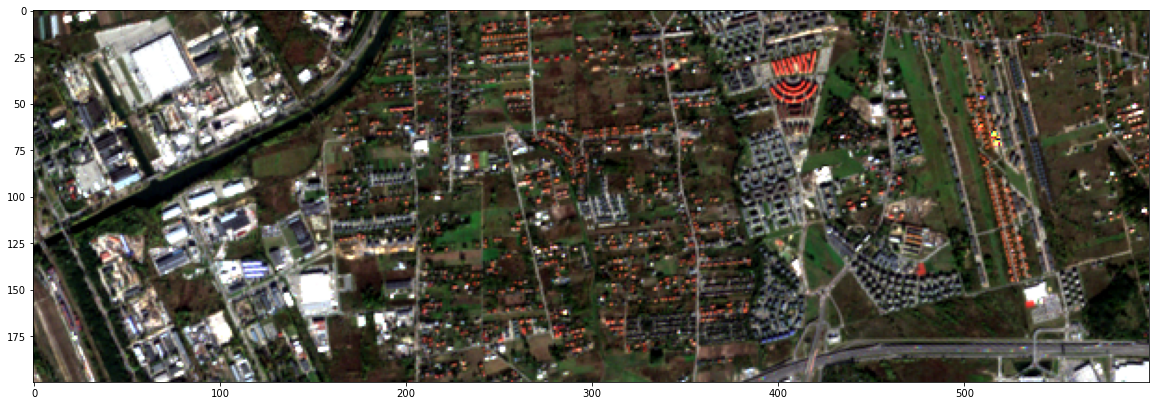

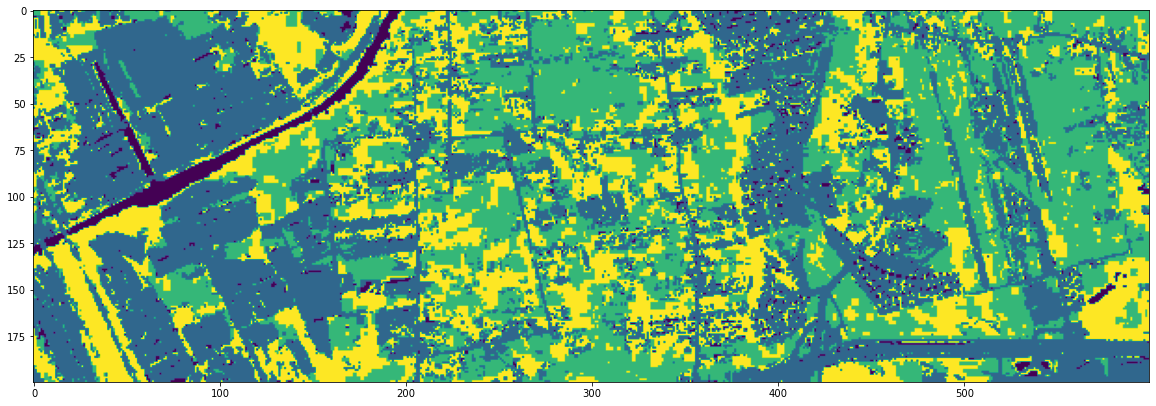

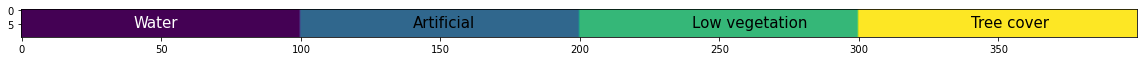

In [23]:
# Plot the original image
plt.figure(figsize=(20,10))
plt.imshow(im_comp)

# Plot the classified image
plt.figure(figsize=(20,10))
plt.imshow(Y_im_dt)

# Plot the legend
fig = plt.figure(figsize=(20,1))
ax = fig.add_subplot(111)
plt.imshow(np.hstack((np.zeros((10,100)), np.ones((10,100)),2*np.ones((10,100)),3*np.ones((10,100)))))
ax.text(40, 6, 'Water', fontsize=15,  color='white')
ax.text(140, 6, 'Artificial', fontsize=15,  color='black')
ax.text(240, 6, 'Low vegetation', fontsize=15,  color='black')
ax.text(340, 6, 'Tree cover', fontsize=15,  color='black')

<br>

### 5.2 Prediction with the trained Random Forest model

Next, we repeat the prediction process with the trained Random Forest model `rf_clf`. You can use again the function `predict()` to predict the land cover class for each pixel of the Sentinel-2 image.

In [24]:
Y_pred_rf = rf_clf.predict(X_all)

Next, we also want to visualize the land cover classification created by the Random Forest classifier. Here as well, we have to reshape the output array into the original dimension of the Sentinel-2 image with the help of the `reshape()` function.

In [25]:
Y_im_rf = Y_pred_rf.reshape(coll[1].shape)
Y_im_rf.shape

(200, 600)

Next, we plot again the original image followed by the classified image followed by a legend specifying the land cover classes.

Text(340, 6, 'Tree cover')

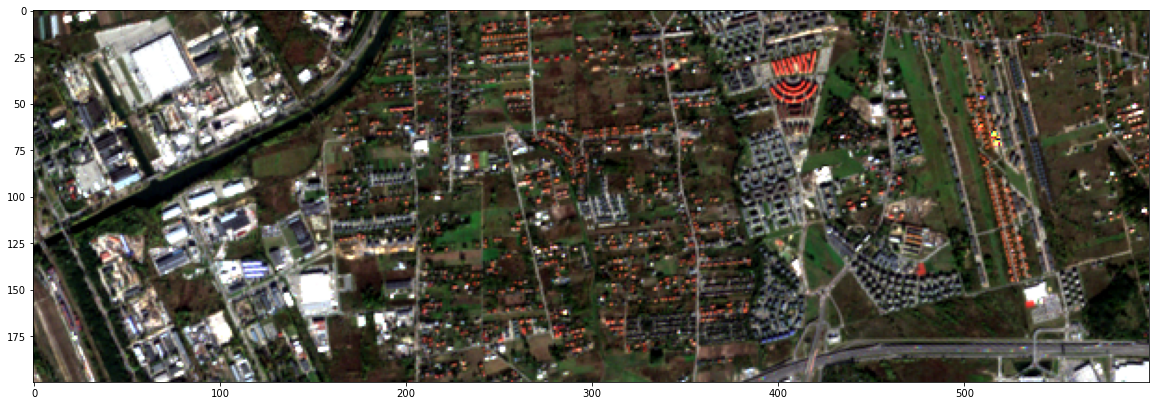

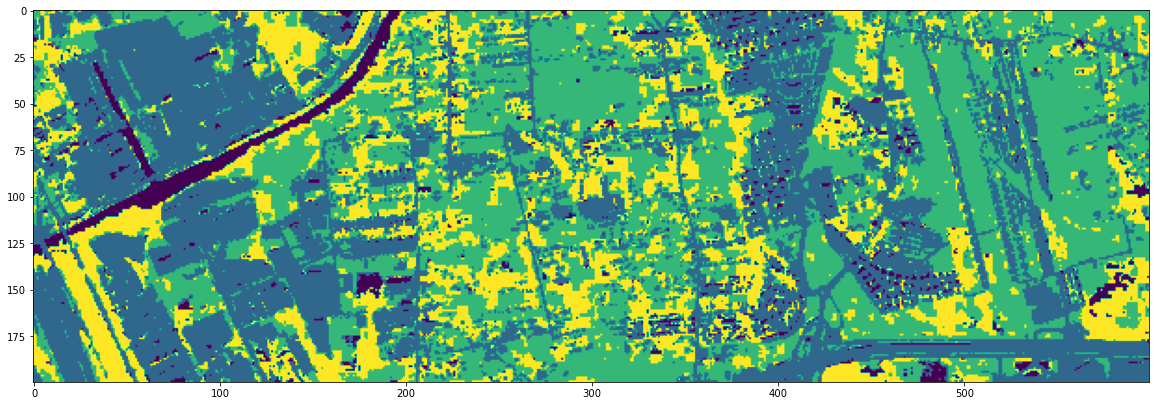

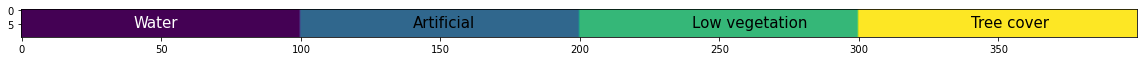

In [26]:
# original image
plt.figure(figsize=(20,10))
plt.imshow(im_comp)

# visualisation of the classification results
plt.figure(figsize=(20,10))
plt.imshow(Y_im_rf)

# legend
fig = plt.figure(figsize=(20,1))
ax = fig.add_subplot(111)
plt.imshow(np.hstack((np.zeros((10,100)), np.ones((10,100)),2*np.ones((10,100)),3*np.ones((10,100)))))
ax.text(40, 6, 'Water', fontsize=15,  color='white')
ax.text(140, 6, 'Artificial', fontsize=15,  color='black')
ax.text(240, 6, 'Low vegetation', fontsize=15,  color='black')
ax.text(340, 6, 'Tree cover', fontsize=15,  color='black')

<br>

### 5.3 Prediction with the trained Support Vector Machine model

As a last step, we also predict the land cover classes with the help of the trained Support Vector Machine model. You can use again the function `predict()` to classify each pixel of the Sentinel-2 image.

In [27]:
Y_pred_svm = svm_clf.predict(X_all)

Next, we want to bring the predictec land cover classes into the original shape of the Sentinel-2 image, with the help of the `reshape()` function.

In [28]:
Y_im_svm = Y_pred_svm.reshape(coll[1].shape)
Y_im_svm.shape

(200, 600)

As a last step, we plot again the original image followed by the classified image followed by a legend specifying the land cover classes.

Text(340, 6, 'Tree cover')

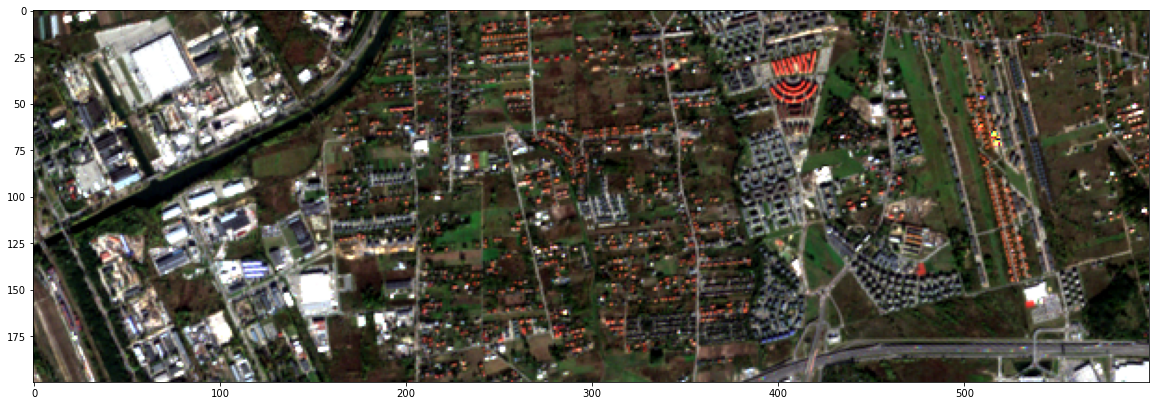

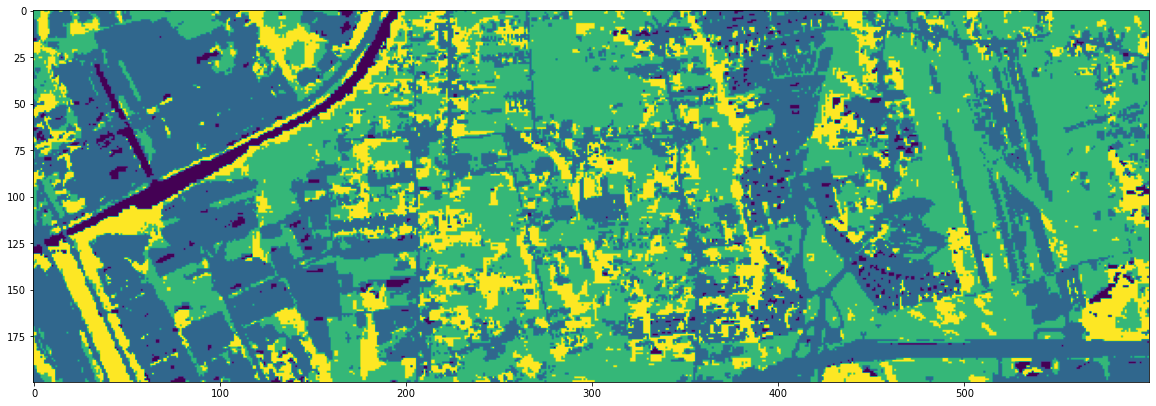

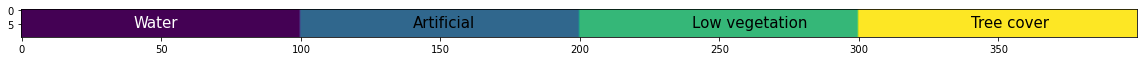

In [29]:
# original image
plt.figure(figsize=(20,10))
plt.imshow(im_comp)

# visualisation of the predicted results
plt.figure(figsize=(20,10))
plt.imshow(Y_im_svm)

# visualisation of the legend
fig = plt.figure(figsize=(20,1))
ax = fig.add_subplot(111)
plt.imshow(np.hstack((np.zeros((10,100)), np.ones((10,100)),2*np.ones((10,100)),3*np.ones((10,100)))))
ax.text(40, 6, 'Water', fontsize=15,  color='white')
ax.text(140, 6, 'Artificial', fontsize=15,  color='black')
ax.text(240, 6, 'Low vegetation', fontsize=15,  color='black')
ax.text(340, 6, 'Tree cover', fontsize=15,  color='black')

<br>

## <a id='evaluate_3d2'></a>6. Evaluate the classification performance

The last step is to evaluate the performance of the three classifiers in order to better assess the accuracy of the land cover predictions. The evaluation is done with a set of 100 independent `validation` data points, which were manually selected as validation labels.

The first step is to load the 100 validation data points, which are provided in a [.txt file](./validation_data/validation_points.txt) in the folder `./validation_data/`. The validation data consists of 100 rows and three columns:
* `First column`: Y is the horizontal pixel coordinate of the validation point
* `Second column`: X is the vertical pixel coordinate of the validation point
* `Third column`: C is the land cover class index (0 for water, 1 for artificial surfaces, 2 for low vegetation and 3 for tree cover) for the respective validation point

You can load the .txt file with the function `np.loadtxt()`.

In [30]:
p_val = np.loadtxt('./validation_data/validation_points.txt',dtype='int')
p_val.shape

(100, 3)

<br>

Let us visualize the `validation` points on top of the original Sentinel-2 image. You can see that the validation points are equally distributed across the image.

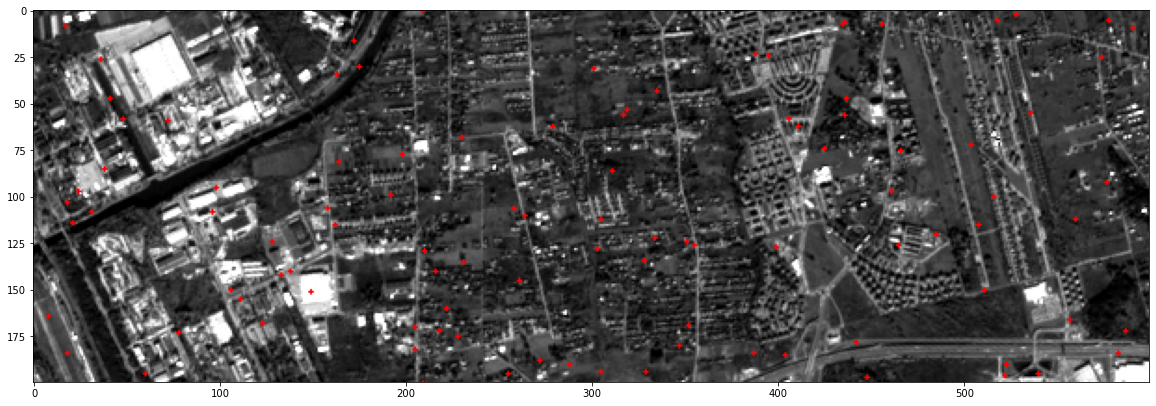

In [31]:
im_comp_p=np.zeros(im_comp.shape)
im_comp_p[:,:,0]=rgb2gray(im_comp)
im_comp_p[:,:,1]=rgb2gray(im_comp)
im_comp_p[:,:,2]=rgb2gray(im_comp)

# marking in red the validation points
im_comp_p[p_val[:,0],p_val[:,1],0] =1
im_comp_p[p_val[:,0],p_val[:,1],1] =0
im_comp_p[p_val[:,0],p_val[:,1],2] =0

im_comp_p[p_val[:,0]+1,p_val[:,1],0] =1
im_comp_p[p_val[:,0]+1,p_val[:,1],1] =0
im_comp_p[p_val[:,0]+1,p_val[:,1],2] =0

im_comp_p[p_val[:,0]-1,p_val[:,1],0] =1
im_comp_p[p_val[:,0]-1,p_val[:,1],1] =0
im_comp_p[p_val[:,0]-1,p_val[:,1],2] =0

im_comp_p[p_val[:,0],p_val[:,1]+1,0] =1
im_comp_p[p_val[:,0],p_val[:,1]+1,1] =0
im_comp_p[p_val[:,0],p_val[:,1]+1,2] =0

im_comp_p[p_val[:,0],p_val[:,1]-1,0] =1
im_comp_p[p_val[:,0],p_val[:,1]-1,1] =0
im_comp_p[p_val[:,0],p_val[:,1]-1,2] =0

plt.figure(figsize=(20,10))
plt.imshow(im_comp_p)

<br>

Now, with the help of the validation points, we can evaluate the accuracy of the three land cover classifications. Two common metrics to evaluate supervised classifications are `overall accuracy` and `confusion matrix`. With both metrics, you compare for each of the validation point locations the true land cover class with the predicted land cover for the same pixel.

As a first step, for each of the validation points, we need to retrieve the predicted land cover class from each of the three classifiers.

In [32]:
pred_dt = Y_im_dt[p_val[:,0],p_val[:,1]] # Decision Tree
pred_rf = Y_im_rf[p_val[:,0],p_val[:,1]] # Random Forest
pred_svm = Y_im_svm[p_val[:,0],p_val[:,1]] # SVM

<br>

First, we calculate the <a href='https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html' target='_blank'>accuracy_score</a> for each of the three classifiers. You can use the function `accuracy_score()` from scikit-learn's `metrics` module.

In [33]:
ovAcc_dt = accuracy_score(p_val[:,2],pred_dt)
print("Overall accuracy for Decision Tree: " + str(100*ovAcc_dt) + "%")

ovAcc_rf = accuracy_score(p_val[:,2],pred_rf)
print("Overall accuracy for Random Forest: " + str(100*ovAcc_rf) + "%")

ovAcc_svm = accuracy_score(p_val[:,2],pred_svm)
print("Overall accuracy for Support Vector Machine: " + str(100*ovAcc_svm) + "%")

Overall accuracy for Decision Tree: 84.0%
Overall accuracy for Random Forest: 85.0%
Overall accuracy for Support Vector Machine: 85.0%


<br>

Another evaluation score is the <a href='https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html' target='_blank'>confusion_matrix</a>. You can calculate the confusion matrix between true and predicted land cover classes with the function `confusion_matrix()` from scikit-learn's `metrics` module. With the function `ConfusionMatrixDisplay()`, you can visualize the confusion matrix for the three land cover classifications.

A confusion matrix helps you to better understand, which land use classes are classified well by a trained classifier and which ones are falsely classified.

In [34]:
confM_dt = confusion_matrix(p_val[:,2],pred_dt)
confM_rf = confusion_matrix(p_val[:,2],pred_rf)
confM_svm = confusion_matrix(p_val[:,2],pred_svm)

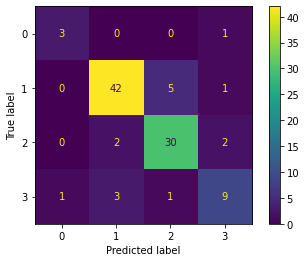

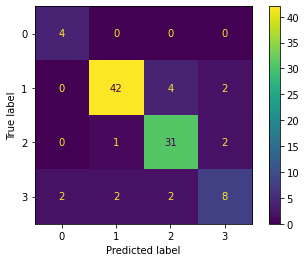

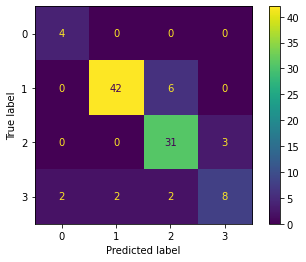

In [35]:
disp = ConfusionMatrixDisplay(confM_dt)
disp.plot()
disp = ConfusionMatrixDisplay(confM_rf)
disp.plot()
disp = ConfusionMatrixDisplay(confM_svm)
disp.plot()

<br>

<br>

<a href='https://www.futurelearn.com/courses/artificial-intelligence-for-earth-monitoring/1/steps/1280516' target='_blank'><< Back to FutureLearn</a><br>

<hr>

<img src='../../img/copernicus_logo.png' alt='Copernicus logo' align='left' width='20%'></img>

Course developed for <a href='https://www.eumetsat.int/' target='_blank'> EUMETSAT</a>, <a href='https://www.ecmwf.int/' target='_blank'> ECMWF</a> and <a href='https://www.mercator-ocean.fr/en/' target='_blank'> Mercator Ocean International</a> in support of the <a href='https://www.copernicus.eu/en' target='_blank'> EU's Copernicus Programme</a> and the <a href='https://wekeo.eu/' target='_blank'> WEkEO platform</a>.
